# PROJECT - AMAZON PRODUCT REVIEW ANALYIS
# TIME SERIES ANALYSIS
### ◆ The Time Series can be used to understand trends in sales or purchases,such as whether there is an overall upward or downward trend,seasonal patterns,and any irregular fluctuations.This information  can be used to make informed business decisions,such as adjusting product levels,forcasting demand and making marketing or promotional strategies.

### ◆ In this Time series analysis for predicting the demand of a particular category we are using month wise count of produts ,it is likely that we are looking at the numer of units sold or the number of products purchased over time for a specific category

## Importing all Required libraries

In [1]:
# import libraries
import numpy as np
import pandas as pd
import gzip                            # to extract file from zip file
import json  

#decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# dickey fuller test for stationarity
from statsmodels.tsa.stattools import acf,pacf,adfuller

# ARIMA
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima


# plots
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error

# Ljung-Box test for model goodness
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

### Defining functions for time series analysis

In [2]:
# stationarity check
def checkStationarity(data):
    pvalue = adfuller(data)[1]
    print('pvalue:',pvalue)

    if pvalue < 0.05:
        msg = "Data is Stationary. Proceed to model building"
    else:
        msg = " Data is not Stationary. Make the data stationary before model building"

    return msg

# Decomposition
def tsa_comp(df):
    decomp = seasonal_decompose(df, period=12, model='additive')
    d_trend = decomp.trend
    d_seasonal = decomp.seasonal
    d_resid = decomp.resid
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,8), facecolor='linen')
    plt.xlabel('date')
    plt.ylabel('count of products')
    plt.suptitle('TIME SERIES COMPONENT ANALYSIS', fontweight='bold', size=20)
    ax1.plot(df, label='Actual Sales')
    ax2.plot(d_trend, label='Trend', c='green')
    ax3.plot(d_seasonal, label='Seasonal', c='orange')
    ax4.plot(d_resid, label='Irregularity', c='pink')
    fig.legend();
    
 # acf and pacf plots
def p_and_q(data):
    fig,ax=plt.subplots(1,2,figsize=(15,5))
    plot_acf(data,lags=40,ax=ax[0])
    plot_pacf(data,lags=40,ax=ax[1]);

## CD's and Vinyl Dataset

### Importing the data

In [3]:
cd_data=pd.read_csv("C:/Users/sandp/Downloads/cd_data_final.csv")

In [4]:
cd_data.head()

,reviewerID,asin,verified,review,ratings,date,summary,unixReviewTime,category,description,...,Sentiment,word_count,char_count,avg_word,polarity,label,year,rating_class_num,review_length,review_length_bin
0,A2LBDC9ZGSCAE6,0005164885,True,christmas tso goes together like rudolph santa,5.0,2018-02-22,TSO...what more do you need to know?,1519257600,"['CDs & Vinyl', 'Holiday & Wedding']","['This is a concept album all the way, with ta...",...,Positive,7,46,5.7,0.000000,1.0,2018,1,7,"(0, 100]"
1,A2ZB6AHRM0ZLLW,0005164885,True,good,4.0,2018-02-14,Four Stars,1518566400,"['CDs & Vinyl', 'Holiday & Wedding']","['This is a concept album all the way, with ta...",...,Positive,1,4,4.0,0.700000,1.0,2018,1,1,"(0, 100]"
2,A1LU1VWVVCU85F,0005164885,True,good sound holiday,5.0,2018-02-10,nice,1518220800,"['CDs & Vinyl', 'Holiday & Wedding']","['This is a concept album all the way, with ta...",...,Positive,3,18,5.3,0.550000,1.0,2018,1,3,"(0, 100]"
3,A3VUWBZF2U32TJ,0005164885,True,item arrived quickly described,5.0,2018-01-28,Five Stars,1517097600,"['CDs & Vinyl', 'Holiday & Wedding']","['This is a concept album all the way, with ta...",...,Positive,4,30,6.7,0.333333,1.0,2018,1,4,"(0, 100]"
4,AV3DKV2TW5B3C,0005164885,True,great album,5.0,2018-01-10,Five Stars,1515542400,"['CDs & Vinyl', 'Holiday & Wedding']","['This is a concept album all the way, with ta...",...,Positive,2,11,5.0,0.800000,1.0,2018,1,2,"(0, 100]"


### Extracting month and year from date

In [5]:
cd_data['date'] = pd.to_datetime(cd_data['date'])

In [6]:
cd_data['Year'] =cd_data['date'].dt.year 
cd_data['Month'] = cd_data['date'].dt.month 
cd_data.head()

,reviewerID,asin,verified,review,ratings,date,summary,unixReviewTime,category,description,...,char_count,avg_word,polarity,label,year,rating_class_num,review_length,review_length_bin,Year,Month
0,A2LBDC9ZGSCAE6,0005164885,True,christmas tso goes together like rudolph santa,5.0,2018-02-22,TSO...what more do you need to know?,1519257600,"['CDs & Vinyl', 'Holiday & Wedding']","['This is a concept album all the way, with ta...",...,46,5.7,0.000000,1.0,2018,1,7,"(0, 100]",2018,2
1,A2ZB6AHRM0ZLLW,0005164885,True,good,4.0,2018-02-14,Four Stars,1518566400,"['CDs & Vinyl', 'Holiday & Wedding']","['This is a concept album all the way, with ta...",...,4,4.0,0.700000,1.0,2018,1,1,"(0, 100]",2018,2
2,A1LU1VWVVCU85F,0005164885,True,good sound holiday,5.0,2018-02-10,nice,1518220800,"['CDs & Vinyl', 'Holiday & Wedding']","['This is a concept album all the way, with ta...",...,18,5.3,0.550000,1.0,2018,1,3,"(0, 100]",2018,2
3,A3VUWBZF2U32TJ,0005164885,True,item arrived quickly described,5.0,2018-01-28,Five Stars,1517097600,"['CDs & Vinyl', 'Holiday & Wedding']","['This is a concept album all the way, with ta...",...,30,6.7,0.333333,1.0,2018,1,4,"(0, 100]",2018,1
4,AV3DKV2TW5B3C,0005164885,True,great album,5.0,2018-01-10,Five Stars,1515542400,"['CDs & Vinyl', 'Holiday & Wedding']","['This is a concept album all the way, with ta...",...,11,5.0,0.800000,1.0,2018,1,2,"(0, 100]",2018,1


### Extracting the most demanded product from cd vinyl category

In [7]:
cd_data['title']=cd_data['title'].replace(to_replace='<span id="parentalAdvisory" class="a-size-medium a-color-secondary a-text-normal"',value='parentalAdvisory',regex=True)
cd_data['title']=cd_data['title'].replace(to_replace='<span class="a-size-medium a-color-secondary a-text-normal"',value='parentalAdvisory',regex=True)
cd_data['title'].value_counts()

parentalAdvisory                                      45002
Greatest Hits                                          3839
Ultimate Collection                                    1194
The Definitive Collection                              1152
Millennium Collection - 20th Century Masters           1079
                                                      ...  
Avalon: A Tribute To Mississippi John Hurt                1
Last Kiss: The Definitive Collection                      1
Two's Company: The Duets                                  1
Outro Lugar                                               1
Dream City - Essential Recordings Vol 2, 1997-2006        1
Name: title, Length: 52957, dtype: int64

In [8]:
cd_vinyl_df=cd_data[cd_data['title']=='parentalAdvisory']

In [9]:
cd_vinyl_df.head()

,reviewerID,asin,verified,review,ratings,date,summary,unixReviewTime,category,description,...,char_count,avg_word,polarity,label,year,rating_class_num,review_length,review_length_bin,Year,Month
4304,A2U49LUUY4IKQQ,7799627174,False,elvis recorded many great love songs career tr...,5.0,2005-04-13,Good selection of love songs by the King,1113350400,"['CDs & Vinyl', 'Pop', 'Oldies']",['ASIAN IMPORT FROM BMG/SONY. SEALED SHIPS FIR...,...,655,6.0,0.340741,1.0,2005,1,94,"(0, 100]",2005,4
4305,A3TVY5KATKED7X,7799627174,False,long sex symbol last isnt time seaze repackagi...,4.0,2005-02-20,another mixed bag?,1108857600,"['CDs & Vinyl', 'Pop', 'Oldies']",['ASIAN IMPORT FROM BMG/SONY. SEALED SHIPS FIR...,...,619,6.2,0.110082,1.0,2005,1,86,"(0, 100]",2005,2
4306,A1GIIPXONCEEHP,7799627174,False,elvis valentines day offering certainly less f...,3.0,2005-02-01,+ 1/2 stars...For Romantics Only,1107216000,"['CDs & Vinyl', 'Pop', 'Oldies']",['ASIAN IMPORT FROM BMG/SONY. SEALED SHIPS FIR...,...,568,6.4,0.255556,0.0,2005,1,77,"(0, 100]",2005,2
4307,A1KUJB9K0TFD74,7799627174,True,almost every elvis rca lpbut wanted cd collection,5.0,2015-02-04,Five Stars,1423008000,"['CDs & Vinyl', 'Pop', 'Oldies']",['ASIAN IMPORT FROM BMG/SONY. SEALED SHIPS FIR...,...,49,5.2,0.000000,1.0,2015,1,8,"(0, 100]",2015,2
4308,A1OIU0S0MLG8TG,7799627174,True,like elvis like love songs album sings best lo...,5.0,2013-01-18,Love Elvis!!!,1358467200,"['CDs & Vinyl', 'Pop', 'Oldies']",['ASIAN IMPORT FROM BMG/SONY. SEALED SHIPS FIR...,...,80,4.8,0.730000,1.0,2013,1,14,"(0, 100]",2013,1


### Making column for month wise count of asin- that is the unique id of products

In [10]:
product_monthly_count=cd_vinyl_df.groupby(['Month','asin']).size().reset_index(name='count')
product_monthly_count

,Month,asin,count
0,1,7799627174,1
1,1,7883938797,3
2,1,807232053X,12
3,1,B000000112,4
4,1,B0000004X1,8
...,...,...,...
11597,12,B01FSZ2JCS,1
11598,12,B01G7NECSY,1
11599,12,B01GLHRLTI,1
11600,12,B01GVQWS4C,1


In [11]:
cd_df=pd.merge(cd_vinyl_df,product_monthly_count)
cd_df.head()

,reviewerID,asin,verified,review,ratings,date,summary,unixReviewTime,category,description,...,avg_word,polarity,label,year,rating_class_num,review_length,review_length_bin,Year,Month,count
0,A2U49LUUY4IKQQ,7799627174,False,elvis recorded many great love songs career tr...,5.0,2005-04-13,Good selection of love songs by the King,1113350400,"['CDs & Vinyl', 'Pop', 'Oldies']",['ASIAN IMPORT FROM BMG/SONY. SEALED SHIPS FIR...,...,6.0,0.340741,1.0,2005,1,94,"(0, 100]",2005,4,1
1,A3TVY5KATKED7X,7799627174,False,long sex symbol last isnt time seaze repackagi...,4.0,2005-02-20,another mixed bag?,1108857600,"['CDs & Vinyl', 'Pop', 'Oldies']",['ASIAN IMPORT FROM BMG/SONY. SEALED SHIPS FIR...,...,6.2,0.110082,1.0,2005,1,86,"(0, 100]",2005,2,3
2,A1GIIPXONCEEHP,7799627174,False,elvis valentines day offering certainly less f...,3.0,2005-02-01,+ 1/2 stars...For Romantics Only,1107216000,"['CDs & Vinyl', 'Pop', 'Oldies']",['ASIAN IMPORT FROM BMG/SONY. SEALED SHIPS FIR...,...,6.4,0.255556,0.0,2005,1,77,"(0, 100]",2005,2,3
3,A1KUJB9K0TFD74,7799627174,True,almost every elvis rca lpbut wanted cd collection,5.0,2015-02-04,Five Stars,1423008000,"['CDs & Vinyl', 'Pop', 'Oldies']",['ASIAN IMPORT FROM BMG/SONY. SEALED SHIPS FIR...,...,5.2,0.000000,1.0,2015,1,8,"(0, 100]",2015,2,3
4,A1OIU0S0MLG8TG,7799627174,True,like elvis like love songs album sings best lo...,5.0,2013-01-18,Love Elvis!!!,1358467200,"['CDs & Vinyl', 'Pop', 'Oldies']",['ASIAN IMPORT FROM BMG/SONY. SEALED SHIPS FIR...,...,4.8,0.730000,1.0,2013,1,14,"(0, 100]",2013,1,1


### Convert the data into proper time series data format

In [12]:
cd_df['Date'] = pd.to_datetime(cd_df['date'])
cd_df = cd_df.set_index('Date')
cd_df=cd_df.sort_values(by=['Date'])

### Selecting the relevant feature for analysis

In [13]:
data1=cd_df[['count']]
data1

,count
Date,
1998-02-18,28
1998-02-19,18
1998-03-17,8
1998-03-26,7
1998-03-27,7
...,...
2018-05-13,2
2018-05-13,2
2018-05-25,13


In [14]:
# resampling
data1=data1.resample('M').mean()
data1.head()

,count
Date,
1998-02-28,23.000000
1998-03-31,7.333333
1998-04-30,13.666667
1998-05-31,3.000000
1998-06-30,11.800000


In [15]:
data1.tail()

,count
Date,
2018-03-31,13.142857
2018-04-30,11.280000
2018-05-31,7.041667
2018-06-30,20.000000
2018-07-31,11.000000


In [16]:
data1.isnull().sum()

count    0
dtype: int64

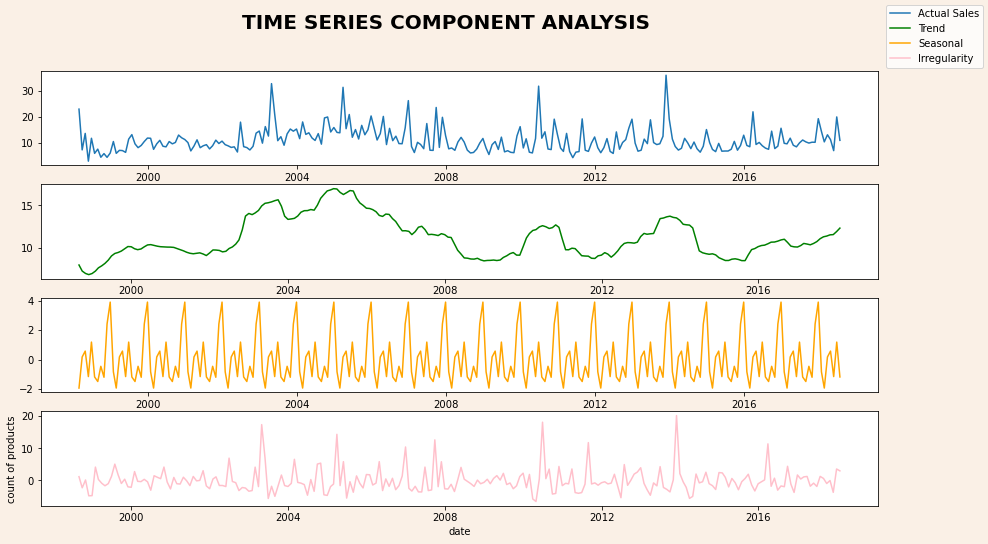

In [17]:
tsa_comp(data1)

By analysing the trend component we can see a downward trend .
It shows some repeating patterns so that we can say our data has seasonality.

### checking the stationarity of data

In [18]:
checkStationarity(data1)

pvalue: 0.005043662289976434


'Data is Stationary. Proceed to model building'

### Splitting the data into train and test parts

In [19]:
ratio = 0.7
rows = int(ratio * len(data1))
train1 =data1[:rows]
test1 = data1[rows:]

print("Total={}, Train={}, Test={}".format(len(data1), len(train1), len(test1)))

Total=246, Train=172, Test=74


### Plotting ACF and PACF 

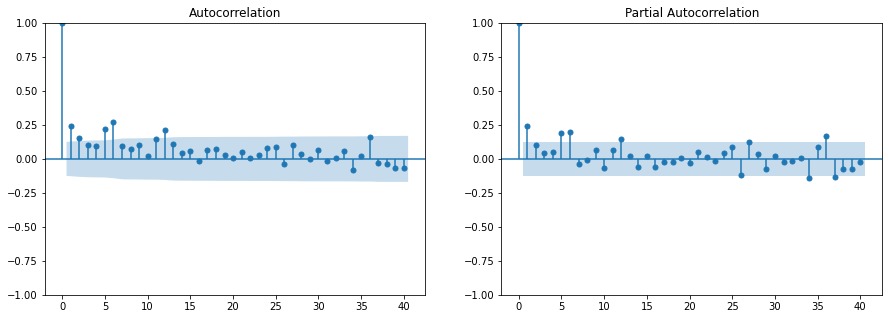

In [20]:
p_and_q(data1)

From ACF plot we can select the value of q as 4 and from PACF plot value of p can taken as 10.
Now we want to check different combinations of p and q for finding the best model

### Finding the best values of p and q

In [21]:
d=0;
lis=[]
for p in range(6):
    for q in range(4):
        lis.append((p,d,q))

# building model
model=[]
for i in lis:
    m =ARIMA(train1, order=i).fit() 
    model.append(m)

# checking model is good or not
model_st=[]
c=1
for i in model:
    pvalue = sm.stats.acorr_ljungbox(i.resid, lags=[1], return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print(f'Model {c} Not a good model')
    else:
        print(f'Model {c} Good model')
    c+=1

Model 1 Not a good model
Model 2 Good model
Model 3 Good model
Model 4 Good model
Model 5 Good model
Model 6 Good model
Model 7 Good model
Model 8 Good model
Model 9 Good model
Model 10 Good model
Model 11 Good model
Model 12 Good model
Model 13 Good model
Model 14 Good model
Model 15 Good model
Model 16 Good model
Model 17 Good model
Model 18 Good model
Model 19 Good model
Model 20 Good model
Model 21 Good model
Model 22 Good model
Model 23 Good model
Model 24 Good model


In [22]:
aic=[]
bic=[]
for i in model[0:]:
    aic.append(i.aic)
    bic.append(i.bic)

# predicting values
forecast=[]
for i in model[0:]:
    fcast = i.predict(start=len(train1), end=len(train1)+len(test1)-1)
    forecast.append(fcast)

# calculating MSE and RMSE score
MSE = []
RMSE = []
for i in forecast:
    mse = mean_squared_error(test1, i)
    rmse = np.sqrt(mse)
    MSE.append(mse)
    RMSE.append(rmse)

# printing model numbers
model_no=[]
for i in range(0,len(model)):
    model_no.append('Model '+str(i))
    
# dataframe of all results
df_results = pd.DataFrame({'Model No.': model_no, '(p, d, q)':lis[0:], 'AIC': aic, 'BIC': bic, 'MSE': MSE, 'RMSE': RMSE})
df_results

,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
0,Model 0,"(0, 0, 0)",1045.098058,1051.393047,21.135241,4.597308
1,Model 1,"(0, 0, 1)",1038.871933,1048.314416,21.023323,4.585120
2,Model 2,"(0, 0, 2)",1034.390683,1046.980661,21.155977,4.599563
3,Model 3,"(0, 0, 3)",1035.862500,1051.599972,21.117032,4.595327
4,Model 4,"(1, 0, 0)",1035.767907,1045.210390,21.013282,4.584025
5,Model 5,"(1, 0, 1)",1024.228498,1036.818476,21.469486,4.633518
6,Model 6,"(1, 0, 2)",1026.149717,1041.887189,21.459466,4.632436
7,Model 7,"(1, 0, 3)",1028.090694,1046.975661,21.454975,4.631952
8,Model 8,"(2, 0, 0)",1032.566305,1045.156283,21.096733,4.593118
9,Model 9,"(2, 0, 1)",1026.147330,1041.884802,21.458981,4.632384


In [23]:
print('Taking model with lowest RMSE score:')
df_results[df_results.RMSE==df_results.RMSE.min()]


Taking model with lowest RMSE score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
4,Model 4,"(1, 0, 0)",1035.767907,1045.21039,21.013282,4.584025


In [24]:
print('Taking model with lowest BIC score:')

df_results[df_results.BIC==df_results.BIC.min()]

Taking model with lowest BIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
5,Model 5,"(1, 0, 1)",1024.228498,1036.818476,21.469486,4.633518


In [25]:
print('Taking model with lowest AIC score:')
df_results[df_results.AIC==df_results.AIC.min()]

Taking model with lowest AIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
15,Model 15,"(3, 0, 3)",1021.773553,1046.953508,22.111196,4.702254


#### Here we are getting two models with least RMSE and AIC values.By Ljung box test it is given that model 0 is not good .so considering Model11(4,1,3) for making forecast 

### Building the model with selected values of p and q

In [26]:
p=6;q=3;d=0 
P=1;Q=1;D=0
m1 = sm.tsa.statespace.SARIMAX(data1['count'],order=(p,d,q),seasonal_order=(P,D,Q,12)).fit()
# summarise the model
m1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                count   No. Observations:                  246
Model:             SARIMAX(6, 0, 3)x(1, 0, [1], 12)   Log Likelihood                -717.959
Date:                              Tue, 14 Feb 2023   AIC                           1459.917
Time:                                      10:44:04   BIC                           1501.981
Sample:                                  02-28-1998   HQIC                          1476.855
                                       - 07-31-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1892      0.203      0.934      0.350      -0.208       0.586
ar.L2         -0.0291      0.193     -0.151      0.880      -0.407       0.348
ar.L3          0.6281      0.173      3.627      0.000       0.289       0.967
ar.L4         -0.0934      0.102     -0.914      0.361      -0.294       0.107
ar.L5          0.0908      0.078      1.170      0.242      -0.061       0.243
ar.L6          0.1832      0.104      1.768      0.077      -0.020       0.386
ma.L1          0.0157      0.202      0.078      0.938      -0.379       0.411
ma.L2          0.1822      0.170      1.070      0.285      -0.152       0.516
ma.L3         -0.6118      0.145     -4.215      0.000      -0.896      -0.327
ar.S.L12       0.9818      0.073     13.442      0.000       0.839       1.125
ma.S.L12      -0.9317      0.144     -6.479      0.000      -1.214      -0.650
sigma2        19.4105      1.334     14.548      0.000      16.795      22.026
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               611.42
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             1.91
Prob(H) (two-sided):                  0.81   Kurtosis:                         9.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
start = len(train1) 
end = len(train1) + len(test1) - 1

print('start = {}, end = {}'.format(start,end))

start = 172, end = 245


### Predicting using the model

In [28]:
predictions = m1.predict(start,end)
predictions.index=test1.index
print(predictions)

Date
2012-06-30    10.110815
2012-07-31     6.063561
2012-08-31     9.359469
2012-09-30     9.643396
2012-10-31     7.614114
                ...    
2018-03-31    11.892345
2018-04-30    10.726139
2018-05-31    10.369610
2018-06-30    12.998880
2018-07-31    11.550334
Freq: M, Name: predicted_mean, Length: 74, dtype: float64


### Evaluating the model

In [29]:
actual = []; pred = []
test1.reset_index(drop=True)
for i in range(len(predictions)):
    actual.append(test1['count'][i])
    pred.append(predictions[i])

df_res1 = pd.DataFrame({'actual':actual, 'predicted':pred})
df_res1['error'] = df_res1.actual - df_res1.predicted
df_res1.index=test1.index
print(df_res1)

               actual  predicted     error
Date                                      
2012-06-30   5.968085  10.110815 -4.142730
2012-07-31  14.240602   6.063561  8.177041
2012-08-31   7.594595   9.359469 -1.764874
2012-09-30  10.171717   9.643396  0.528321
2012-10-31  11.295181   7.614114  3.681067
...               ...        ...       ...
2018-03-31  13.142857  11.892345  1.250512
2018-04-30  11.280000  10.726139  0.553861
2018-05-31   7.041667  10.369610 -3.327943
2018-06-30  20.000000  12.998880  7.001120
2018-07-31  11.000000  11.550334 -0.550334

[74 rows x 3 columns]


In [30]:
len(df_res1)

74

In [31]:
mse1=mean_squared_error(df_res1.actual,df_res1.predicted)
rmse1=np.sqrt(mse1)
print('mse:',mse1)
print('rmse:',rmse1)

mse: 18.478499161319313
rmse: 4.298662485159694


### Plotting actual and predicted values

Text(0.5, 1.0, 'SARIMA Model. Order=(6,0,3)')

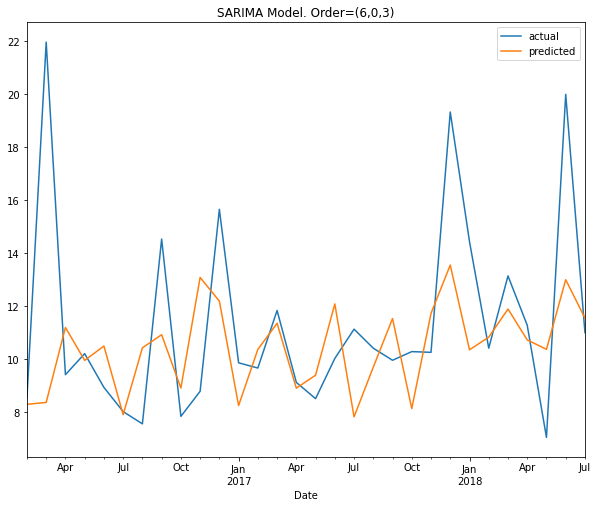

In [32]:
msg = 'SARIMA Model. Order=(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
df_res1.tail(30).actual.plot(figsize=(10,8),legend=True)
df_res1.tail(30).predicted.plot(legend=True)
plt.title(msg)

Our predicted values align with the true values very well it shows that this is a good model.
Error also very less(1.62).

### Future forecasting using the model

In [33]:
# creating a data frame for future dates
future_dates=pd.DataFrame()
future_dates['date']=['2018-07-31','30-09-2018','2018-11-30','2019-01-30','2019-03-31','2019-05-31','2019-07-30']    
future_dates=pd.to_datetime(future_dates['date'])
future_dates=pd.DataFrame(future_dates)


In [34]:

fcast1 = m1.predict(start=len(data1),end=len(data1)+6).rename('Forecast')
fcast1.index=future_dates.date
print(fcast1.head())

date
2018-07-31    11.642430
2018-09-30    12.369368
2018-11-30    10.068835
2019-01-30    13.564134
2019-03-31    16.397258
Name: Forecast, dtype: float64


### Plotting actual and future forecasted values

Text(0, 0.5, 'Count of Products')

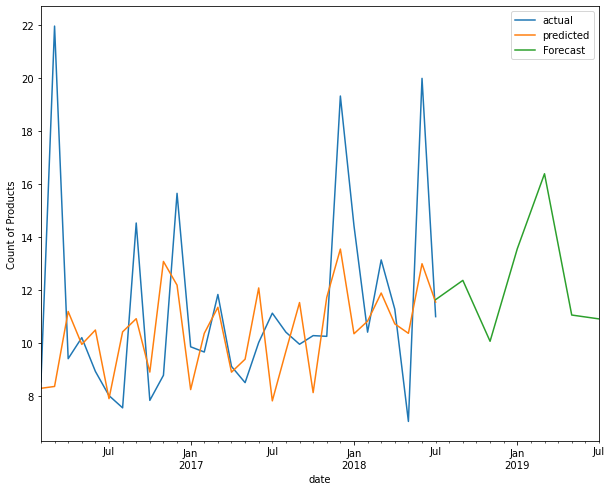

In [35]:
msg = 'SARIMA Model. Order=(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
df_res1.tail(30).actual.plot(figsize=(10,8),legend=True)
df_res1.tail(30).predicted.plot(legend=True)
fcast1.plot(legend=True)
plt.ylabel("Count of Products")


In the above plot green line indicates the future forecasted values of products..it  also showing that there will be decline in demand of CD-vinyl product for next 12 moths

# Office-Products DATA

In [36]:
office_data=pd.read_csv("C:/Users/sandp/Downloads/office_data_final.csv")

In [37]:
office_data['date'] = pd.to_datetime(office_data['date'])

In [38]:
office_data['Year'] =office_data['date'].dt.year 
office_data['Month'] = office_data['date'].dt.month 
office_data.head()

,ratings,verified,date,reviewerID,asin,review,summary,unixReviewTime,category,description,...,char_count,avg_word,polarity,label,year,rating_class_num,review_length,review_length_bin,Year,Month
0,4.0,True,2017-11-07,A2NIJTYWADLK57,0140503528,kids like story really wanted board book one s...,"good story, small size book though",1510012800,"['Office Products', 'Office & School Supplies'...",['Corduroy the bear goes to the launderette wi...,...,62,4.7,-0.016667,1.0,2017,1,11,"(0, 100]",2017,11
1,4.0,True,2017-03-07,A2827D8EEURMP4,0140503528,bought used came great condition almost like n...,Good,1488844800,"['Office Products', 'Office & School Supplies'...",['Corduroy the bear goes to the launderette wi...,...,135,5.8,0.625000,1.0,2017,1,20,"(0, 100]",2017,3
2,5.0,True,2016-06-25,APB6087F4J09J,0140503528,every story book corduroy fantastic book great...,Best Books for All Children,1466812800,"['Office Products', 'Office & School Supplies'...",['Corduroy the bear goes to the launderette wi...,...,146,5.6,0.425000,1.0,2016,1,22,"(0, 100]",2016,6
3,5.0,True,2016-02-21,A2DHERRZIPFU7X,0140503528,purchased book first grade classroom read book...,Great for Math!,1456012800,"['Office Products', 'Office & School Supplies'...",['Corduroy the bear goes to the launderette wi...,...,306,6.0,0.233333,1.0,2016,1,44,"(0, 100]",2016,2
4,5.0,False,2015-08-02,A2XCLJRGFANRC,0140503528,spent numerous years elementary school library...,Love Corduroy,1438473600,"['Office Products', 'Office & School Supplies'...",['Corduroy the bear goes to the launderette wi...,...,447,6.3,0.405208,1.0,2015,1,61,"(0, 100]",2015,8


In [39]:
office_data['title'].value_counts()

Prismacolor 3598T Premier Colored Pencils, Soft Core, 48 Pack                                                                                                                                                1953
Sharpie 37003 Ultra-Fine Permanent Marker, Marks on Paper and Plastic, Resist Fading and Water, AP Certified, Blue Color, Pack of 12                                                                         1420
Pilot G2 Retractable Premium Gel Ink Roller Ball Pens Fine Pt (.7) Dozen Box Red ; Retractable, Refillable &amp; Premium Comfort Grip; Smooth Lines to the End of the Page, Americas #1 Selling Pen Brand    1314
Sharpie Permanent Markers, Fine Point, Purple, 12-Pack (30008)                                                                                                                                               1235
Canon Office and Business MX922 All-In-One Printer, Wireless and mobile printing                                                                                

In [40]:
office_products_df=office_data[office_data['title']=='Prismacolor 3598T Premier Colored Pencils, Soft Core, 48 Pack']  

In [41]:
office_products_df.head()

,ratings,verified,date,reviewerID,asin,review,summary,unixReviewTime,category,description,...,char_count,avg_word,polarity,label,year,rating_class_num,review_length,review_length_bin,Year,Month
40764,5.0,True,2018-05-13,A2MUKNK3NNDQXJ,B00006IEEV,used prismacolor arent usually within budget r...,I love them!,1526169600,"['Office Products', 'Office & School Supplies'...",['Bring your artistic vision to life with Pris...,...,157,5.9,0.475000,1.0,2018,1,23,"(0, 100]",2018,5
40765,5.0,True,2018-05-12,AMKX54XQ6637V,B00006IEEV,beautiful colors rich deep tips slightly soft ...,Beautiful colors! Rich and deep,1526083200,"['Office Products', 'Office & School Supplies'...",['Bring your artistic vision to life with Pris...,...,77,5.5,0.385000,1.0,2018,1,12,"(0, 100]",2018,5
40799,5.0,True,2018-05-09,AI1VKT4EGDAU0,B00006IEEV,amazing colored pencils soft colors extremely ...,Amazing set for artists.,1525824000,"['Office Products', 'Office & School Supplies'...",['Bring your artistic vision to life with Pris...,...,125,6.4,0.253333,1.0,2018,1,17,"(0, 100]",2018,5
40817,5.0,True,2018-05-08,A2MO0GTIK8F9VQ,B00006IEEV,lays buttery smooth blends well love vibrant c...,Best for price and quality,1525737600,"['Office Products', 'Office & School Supplies'...",['Bring your artistic vision to life with Pris...,...,62,5.3,0.355556,1.0,2018,1,10,"(0, 100]",2018,5
40853,3.0,True,2018-05-07,A2AMLMM0EACBLW,B00006IEEV,disappointed love way go tip breaks easily sha...,Disappointed. I love the way they go on but ...,1525651200,"['Office Products', 'Office & School Supplies'...",['Bring your artistic vision to life with Pris...,...,319,5.5,-0.021296,0.0,2018,1,49,"(0, 100]",2018,5


In [42]:
product_monthly_count1=office_products_df.groupby(['Month','asin']).size().reset_index(name='count')
product_monthly_count1

,Month,asin,count
0,1,B00006IEEV,238
1,2,B00006IEEV,183
2,3,B00006IEEV,192
3,4,B00006IEEV,188
4,5,B00006IEEV,145
5,6,B00006IEEV,107
6,7,B00006IEEV,125
7,8,B00006IEEV,166
8,9,B00006IEEV,131
9,10,B00006IEEV,113


In [43]:
office_df=pd.merge(office_products_df,product_monthly_count1)
office_df.head()

,ratings,verified,date,reviewerID,asin,review,summary,unixReviewTime,category,description,...,avg_word,polarity,label,year,rating_class_num,review_length,review_length_bin,Year,Month,count
0,5.0,True,2018-05-13,A2MUKNK3NNDQXJ,B00006IEEV,used prismacolor arent usually within budget r...,I love them!,1526169600,"['Office Products', 'Office & School Supplies'...",['Bring your artistic vision to life with Pris...,...,5.9,0.475000,1.0,2018,1,23,"(0, 100]",2018,5,145
1,5.0,True,2018-05-12,AMKX54XQ6637V,B00006IEEV,beautiful colors rich deep tips slightly soft ...,Beautiful colors! Rich and deep,1526083200,"['Office Products', 'Office & School Supplies'...",['Bring your artistic vision to life with Pris...,...,5.5,0.385000,1.0,2018,1,12,"(0, 100]",2018,5,145
2,5.0,True,2018-05-09,AI1VKT4EGDAU0,B00006IEEV,amazing colored pencils soft colors extremely ...,Amazing set for artists.,1525824000,"['Office Products', 'Office & School Supplies'...",['Bring your artistic vision to life with Pris...,...,6.4,0.253333,1.0,2018,1,17,"(0, 100]",2018,5,145
3,5.0,True,2018-05-08,A2MO0GTIK8F9VQ,B00006IEEV,lays buttery smooth blends well love vibrant c...,Best for price and quality,1525737600,"['Office Products', 'Office & School Supplies'...",['Bring your artistic vision to life with Pris...,...,5.3,0.355556,1.0,2018,1,10,"(0, 100]",2018,5,145
4,3.0,True,2018-05-07,A2AMLMM0EACBLW,B00006IEEV,disappointed love way go tip breaks easily sha...,Disappointed. I love the way they go on but ...,1525651200,"['Office Products', 'Office & School Supplies'...",['Bring your artistic vision to life with Pris...,...,5.5,-0.021296,0.0,2018,1,49,"(0, 100]",2018,5,145


In [44]:
office_df['Date'] = pd.to_datetime(office_df['date'])
office_df = office_df.set_index('Date')
office_df=office_df.sort_values(by=['Date'])

In [45]:
data2=office_df[['count']]
data2

,count
Date,
2009-03-15,192
2009-05-23,145
2009-09-13,131
2009-11-04,160
2010-02-01,183
...,...
2018-05-08,145
2018-05-09,145
2018-05-12,145


In [46]:
# resampling
data2=data2.resample('M').mean()
data2.head()

,count
Date,
2009-03-31,192.0
2009-04-30,NaN
2009-05-31,145.0
2009-06-30,NaN
2009-07-31,NaN


In [47]:
data2.tail()

,count
Date,
2018-01-31,238.0
2018-02-28,183.0
2018-03-31,192.0
2018-04-30,188.0
2018-05-31,145.0


In [48]:
data2.shape

(111, 1)

In [49]:
data2.isnull().sum()

count    21
dtype: int64

In [50]:
data2.dropna(inplace=True)

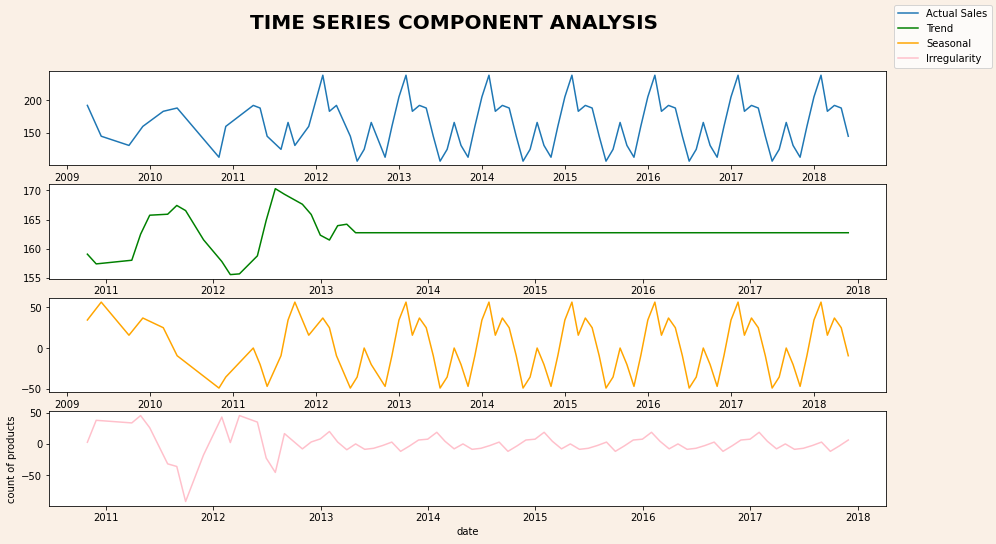

In [51]:
tsa_comp(data2)

Trend component shows that this category is showing an upward trend upto 2018 and then it is decreasing
From the Seasonal component we can see that at the end of an year or starting of next year this category has an off season,and it flunctuates and reaches maximum at the middle of an year

In [52]:
# check the data for stationarity
checkStationarity(data2)

pvalue: 1.4683532222728155e-06


'Data is Stationary. Proceed to model building'

In [53]:
## Split data into train and test parts
ratio = 0.7
rows = int(ratio * len(data2))
train2 =data2[:rows]
test2 = data2[rows:]

print("Total={}, Train={}, Test={}".format(len(data2), len(train2), len(test2)))

Total=90, Train=62, Test=28


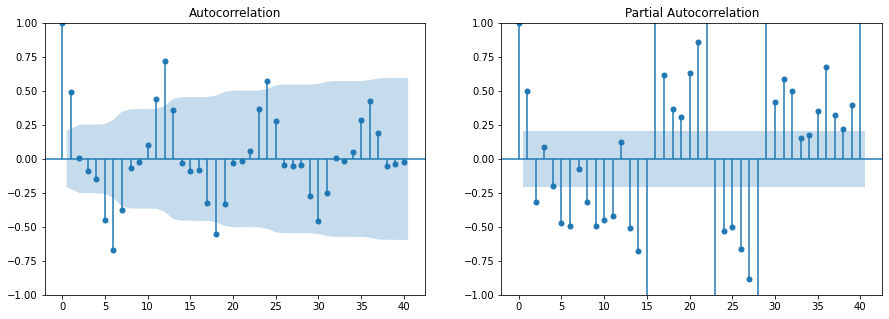

In [54]:
p_and_q(data2)

In [55]:
d=0;
lis2=[]
for p in range(10):
    for q in range(5):
        lis2.append((p,d,q))

# building model
models=[]
for i in lis2:
    m2=ARIMA(train2, order=i).fit() 
    models.append(m2)

# checking model is good or not
model_st2=[]
c=1
for i in models:
    pvalue = sm.stats.acorr_ljungbox(i.resid, lags=[1], return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print(f'Model {c} Not a good model')
    else:
        print(f'Model {c} Good model')
    c+=1

Model 1 Not a good model
Model 2 Good model
Model 3 Good model
Model 4 Good model
Model 5 Good model
Model 6 Good model
Model 7 Good model
Model 8 Good model
Model 9 Good model
Model 10 Good model
Model 11 Good model
Model 12 Good model
Model 13 Good model
Model 14 Good model
Model 15 Good model
Model 16 Good model
Model 17 Good model
Model 18 Good model
Model 19 Good model
Model 20 Good model
Model 21 Good model
Model 22 Good model
Model 23 Good model
Model 24 Good model
Model 25 Good model
Model 26 Good model
Model 27 Good model
Model 28 Good model
Model 29 Good model
Model 30 Good model
Model 31 Good model
Model 32 Good model
Model 33 Good model
Model 34 Good model
Model 35 Good model
Model 36 Good model
Model 37 Good model
Model 38 Good model
Model 39 Good model
Model 40 Good model
Model 41 Good model
Model 42 Good model
Model 43 Good model
Model 44 Good model
Model 45 Good model
Model 46 Good model
Model 47 Good model
Model 48 Good model
Model 49 Good model
Model 50 Good model


In [56]:
aic_value=[]
bic_value=[]
for i in models[0:]:
    aic_value.append(i.aic)
    bic_value.append(i.bic)

# predicting values
forecast2=[]
for i in models[0:]:
    fcast2 = i.predict(start=len(train2), end=len(train2)+len(test2)-1)
    forecast2.append(fcast2)

# calculating MSE and RMSE score
MSE_value = []
RMSE_value = []
for i in forecast2:
    mse = mean_squared_error(test2, i)
    rmse = np.sqrt(mse)
    MSE_value.append(mse)
    RMSE_value.append(rmse)

# printing model numbers
model_nos=[]
for i in range(0,len(models)):
    model_nos.append('Model '+str(i))
    
# dataframe of all results
df_results = pd.DataFrame({'Model No.': model_nos, '(p, d, q)':lis2[0:], 'AIC': aic_value, 'BIC': bic_value, 'MSE': MSE_value, 'RMSE': RMSE_value})
df_results

,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
0,Model 0,"(0, 0, 0)",627.636234,631.890503,1342.345196,36.638029
1,Model 1,"(0, 0, 1)",609.312951,615.694355,1332.846666,36.508173
2,Model 2,"(0, 0, 2)",610.498965,619.007502,1328.491703,36.448480
3,Model 3,"(0, 0, 3)",606.285764,616.921436,1439.818896,37.944946
4,Model 4,"(0, 0, 4)",600.493843,613.256649,1417.611956,37.651188
5,Model 5,"(1, 0, 0)",614.843482,621.224885,1319.438587,36.324077
6,Model 6,"(1, 0, 1)",610.777325,619.285862,1327.482398,36.434632
7,Model 7,"(1, 0, 2)",612.254448,622.890120,1331.859423,36.494649
8,Model 8,"(1, 0, 3)",601.447996,614.210802,1374.393054,37.072807
9,Model 9,"(1, 0, 4)",602.424882,617.314822,1407.380269,37.515067


In [57]:
print('Taking model with lowest RMSE score:')
df_results[df_results.RMSE==df_results.RMSE.min()]


Taking model with lowest RMSE score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
49,Model 49,"(9, 0, 4)",569.825536,601.732551,199.08435,14.109725


In [58]:
print('Taking model with lowest BIC score:')

df_results[df_results.BIC==df_results.BIC.min()]

Taking model with lowest BIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
24,Model 24,"(4, 0, 4)",567.509187,588.780531,232.908002,15.261324


In [59]:
print('Taking model with lowest AIC score:')
df_results[df_results.AIC==df_results.AIC.min()]

Taking model with lowest AIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
24,Model 24,"(4, 0, 4)",567.509187,588.780531,232.908002,15.261324


Since model 2 is not good we are checking with model-15(3,1,0) and model-23(4,1,3)

### Model 15(3,1,0)

In [60]:
p=4;q=4;d=0 
P=1;Q=1;D=0
model15 = sm.tsa.statespace.SARIMAX(data2['count'],order=(p,d,q),seasonal_order=(P,D,Q,12)).fit()
# summarise the model
model15.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                count   No. Observations:                   90
Model:             SARIMAX(4, 0, 4)x(1, 0, [1], 12)   Log Likelihood                -403.377
Date:                              Tue, 14 Feb 2023   AIC                            828.755
Time:                                      10:44:42   BIC                            856.252
Sample:                                           0   HQIC                           839.843
                                               - 90                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7776      0.465      1.673      0.094      -0.133       1.689
ar.L2          0.2596      0.799      0.325      0.745      -1.307       1.826
ar.L3         -0.7705      0.721     -1.068      0.285      -2.184       0.643
ar.L4          0.7277      0.402      1.809      0.071      -0.061       1.516
ma.L1         -0.5270      1.736     -0.304      0.761      -3.929       2.875
ma.L2          0.0169      5.085      0.003      0.997      -9.950       9.984
ma.L3          0.5849      2.467      0.237      0.813      -4.251       5.421
ma.L4         -0.9570      5.040     -0.190      0.849     -10.836       8.921
ar.S.L12       0.9671      0.029     32.932      0.000       0.910       1.025
ma.S.L12      -0.4705      0.159     -2.958      0.003      -0.782      -0.159
sigma2       336.5203   1720.905      0.196      0.845   -3036.391    3709.432
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):                26.44
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                             0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
start = len(train2) 
end = len(train2) + len(test2) - 1

print('start = {}, end = {}'.format(start,end))

start = 62, end = 89


In [62]:
predictions2 = model15.predict(start,end)
predictions2.index=test2.index
print(predictions2)

Date
2016-02-29    188.395746
2016-03-31    195.435890
2016-04-30    180.608439
2016-05-31    143.807743
2016-06-30    114.369602
2016-07-31    131.320979
2016-08-31    163.572881
2016-09-30    131.988875
2016-10-31    114.617954
2016-11-30    158.797483
2016-12-31    203.105181
2017-01-31    230.222818
2017-02-28    182.300585
2017-03-31    192.510717
2017-04-30    186.597296
2017-05-31    146.675966
2017-06-30    110.597672
2017-07-31    125.541646
2017-08-31    163.682270
2017-09-30    134.603886
2017-10-31    117.385932
2017-11-30    157.286087
2017-12-31    199.050815
2018-01-31    231.590993
2018-02-28    186.322197
2018-03-31    194.084480
2018-04-30    184.334750
2018-05-31    142.271149
Name: predicted_mean, dtype: float64


In [63]:
actual2 = []; pred2 = []
for i in range(len(predictions2)):
    actual2.append(test2['count'][i])
    pred2.append(predictions2[i])

df_res2 = pd.DataFrame({'actual':actual2, 'predicted':pred2})
df_res2['error'] = df_res2.actual - df_res2.predicted
df_res2.index=test2.index
print(df_res2)

            actual   predicted     error
Date                                    
2016-02-29   183.0  188.395746 -5.395746
2016-03-31   192.0  195.435890 -3.435890
2016-04-30   188.0  180.608439  7.391561
2016-05-31   145.0  143.807743  1.192257
2016-06-30   107.0  114.369602 -7.369602
2016-07-31   125.0  131.320979 -6.320979
2016-08-31   166.0  163.572881  2.427119
2016-09-30   131.0  131.988875 -0.988875
2016-10-31   113.0  114.617954 -1.617954
2016-11-30   160.0  158.797483  1.202517
2016-12-31   205.0  203.105181  1.894819
2017-01-31   238.0  230.222818  7.777182
2017-02-28   183.0  182.300585  0.699415
2017-03-31   192.0  192.510717 -0.510717
2017-04-30   188.0  186.597296  1.402704
2017-05-31   145.0  146.675966 -1.675966
2017-06-30   107.0  110.597672 -3.597672
2017-07-31   125.0  125.541646 -0.541646
2017-08-31   166.0  163.682270  2.317730
2017-09-30   131.0  134.603886 -3.603886
2017-10-31   113.0  117.385932 -4.385932
2017-11-30   160.0  157.286087  2.713913
2017-12-31   205

In [64]:
mse2=mean_squared_error(df_res2.actual,df_res2.predicted)
rmse2=np.sqrt(mse2)
print('mse of model-15:',mse2)
print('rmse of model-15:',rmse2)

mse of model-15: 15.81089124164617
rmse of model-15: 3.9762911414591073


In [65]:
# creating a data frame for future dates
future_dates=pd.DataFrame()
future_dates['date']=[     
'2018-05-31',
'2018-06-30',    
'2018-07-31',   
'2018-08-31',    
'2018-09-30',    
'2018-10-31',
'2019-01-31',      
'2019-03-31',      
'2019-05-31',    
'2019-06-30',  
'2019-07-31']      
future_dates=pd.to_datetime(future_dates['date'])
future_dates=pd.DataFrame(future_dates)



### Future Forecasting 

In [66]:
sarima_fcast=model15.predict(end,end+10).rename('Forecast')
sarima_fcast.index=future_dates.date

In [67]:
sarima_fcast

date
2018-05-31    142.271149
2018-06-30    110.515255
2018-07-31    130.256705
2018-08-31    168.457824
2018-09-30    133.277909
2018-10-31    114.115243
2019-01-31    157.691692
2019-03-31    202.347799
2019-05-31    233.242868
2019-06-30    182.147708
2019-07-31    189.248884
Name: Forecast, dtype: float64

Text(0, 0.5, 'Count of Products')

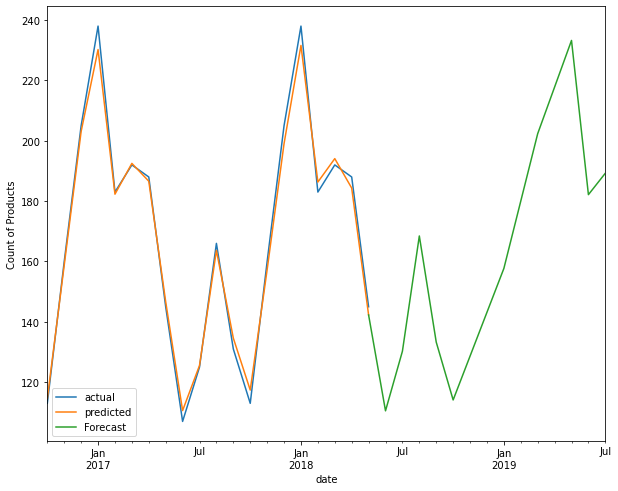

In [68]:
msg = 'SARIMA Model. Order=(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
df_res2.tail(20).actual.plot(figsize=(10,8),legend=True)
df_res2.tail(20).predicted.plot(legend=True)
sarima_fcast.plot(legend=True)
plt.ylabel("Count of Products")


Our model clearly captures the seasonality and trend present in the data so we can say that it is good model

green line indicates  the predicted values for upcoming 3 years. It is  showing that there is a decrease in demand of this office product category.

### Final conclusions from both data set

● We are seeing a downward trend in the count of product IDs in both categories from our time series analysis, it may indicate a decrease in demand for that  products.

●For both CD-vinyl category the demand of product is deeply decreasing from 1997 to 2018.

●For office products the demand is increasing upto the year 2018 and then it shows a downward trend.

● Ending and starting of an year is an off season for both categories and showing a peak at middle of an year.


### Business solution


This can have several potential causes, such as increased competition, changes in consumer preferences, or economic conditions.
To address the situation, we need to consider several potential business solutions such as

●  Conducting market research to understand why demand for the product is decreasing and identify any potential changes in consumer preferences or buying habits.

● Lowering prices to make the product more attractive to price-sensitive consumers.

● Introducing new product variants or improving existing products to make them more appealing to customers.

● Identifying new market segments to target, such as by launching a marketing campaign directed at a different demographic or geographic area.

● Diversifying product portfolio to reduce the dependence on the specific product that is experiencing the downward trend


